<a href="https://colab.research.google.com/github/ariefahshalihah/CNN/blob/main/cnn_rock_paper_scissors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Rock Paper Scissors

In [ ]:
 # import library
from sklearn.model_selection import train_test_split
from shutil import copy
import matplotlib.pyplot as plt
import numpy as np
import zipfile,os
from time import time

import tensorflow as tf
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D, Conv2D, MaxPooling2D
from tensorflow.python.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import plot_model
%matplotlib inline

print(tf.__version__)

2.2.0


## Persiapan Data

In [ ]:
# Unduh dataset dan ekstraksi di direktori Colab (bersifat temporary)
!wget --no-check-certificate https://dicodingacademy.blob.core.windows.net/picodiploma/ml_pemula_academy/rockpaperscissors.zip -O /tmp/rockpaperscissors.zip

zip_ref = zipfile.ZipFile('/tmp/rockpaperscissors.zip', 'r')
zip_ref.extractall('/tmp/')
zip_ref.close()

--2020-07-22 15:07:10--  https://dicodingacademy.blob.core.windows.net/picodiploma/ml_pemula_academy/rockpaperscissors.zip
Resolving dicodingacademy.blob.core.windows.net (dicodingacademy.blob.core.windows.net)... 52.239.197.36
Connecting to dicodingacademy.blob.core.windows.net (dicodingacademy.blob.core.windows.net)|52.239.197.36|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 322873683 (308M) [application/zip]
Saving to: ‘/tmp/rockpaperscissors.zip’

/tmp/rockpapersciss 100%[===================>] 307.92M  9.31MB/s    in 43s     

2020-07-22 15:07:54 (7.20 MB/s) - ‘/tmp/rockpaperscissors.zip’ saved [322873683/322873683]



In [ ]:
# Membagi dataset menjadi Data Training (60%) & Validasi (40%)

path = '/content/rps/'
set_dirs = ['train','val']
sub_dirs = ['paper', 'rock', 'scissors']

# membuat folder train, val serta sub folder terlebih dahulu
for set_dir in set_dirs:
  for sub_dir in sub_dirs:
    try: 
      dir = os.path.join(path, set_dir , sub_dir)      
      os.makedirs(dir)
      print(f'Direktori: {dir:<60} {"Selesai dibuat"}')
      
    except FileExistsError:      
      print(f'Direktori: {dir:<60} {"Sudah dibuat"}')

Direktori: /content/rps/train/paper                                     Selesai dibuat
Direktori: /content/rps/train/rock                                      Selesai dibuat
Direktori: /content/rps/train/scissors                                  Selesai dibuat
Direktori: /content/rps/val/paper                                       Selesai dibuat
Direktori: /content/rps/val/rock                                        Selesai dibuat
Direktori: /content/rps/val/scissors                                    Selesai dibuat


In [ ]:
# Membagi, meng-copy dan menyimpan ke masing-masing folder yang telah dibuat

# fungsi untuk membagi, copy dan simpan
def divide_and_save(path, new_path, set_dirs, sub_dirs):
  for sub_dir in sub_dirs:            
    files = os.listdir(path + sub_dir)        

    # Membagi file
    train, val = train_test_split(files, test_size = 0.4, random_state = 42)

    # Copy dan Simpan file       
    for set_dir in set_dirs:
      dst = os.path.join(new_path, set_dir, sub_dir)
      if set_dir == 'train':
        for file_name in train:          
          if not os.path.exists(os.path.join(dst, file_name)):
            src = os.path.join(path, sub_dir, file_name)
            copy(src, dst)

      elif set_dir == 'val':
        for file_name in val:                  
          if not os.path.exists(os.path.join(dst,file_name)):
            src = os.path.join(path, sub_dir, file_name)
            copy(src, dst)
            
  return print('Proses membagi, copy dan simpan file selesai')


# Menjalankan fungsi
divide_and_save('/tmp/rockpaperscissors/', path, set_dirs, sub_dirs)

Proses membagi, copy dan simpan file selesai


In [ ]:
# Eksplorasi Data

train_paper = len(os.listdir(path+'/train/paper'))
train_rock  = len(os.listdir(path+'/train/rock'))
train_scissors = len(os.listdir(path+'/train/scissors'))

val_paper = len(os.listdir(path+'/val/paper'))
val_rock  = len(os.listdir(path+'/val/rock'))
val_scissors = len(os.listdir(path+'/val/scissors'))

total_train = train_paper + train_rock + train_scissors
total_val   = val_paper + val_rock + val_scissors
total = total_train + total_val

print(total,'Gambar')
print('----', total_train, 'Train')
print('     ----',train_paper,'paper')
print('     ----',train_rock, 'rock')
print('     ----',train_scissors,'scissors')
print('----', total_val,'Val')
print('     ----',val_paper, 'paper')
print('     ----',val_rock, 'rock')
print('     ----',val_scissors, 'scissors')

2188 Gambar
---- 1312 Train
     ---- 427 paper
     ---- 435 rock
     ---- 450 scissors
---- 876 Val
     ---- 285 paper
     ---- 291 rock
     ---- 300 scissors


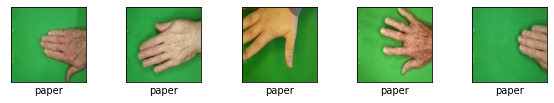

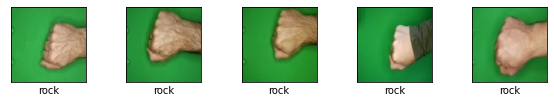

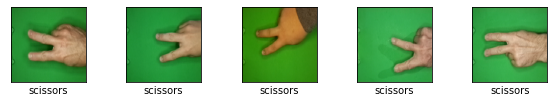

In [ ]:
# Contoh plot gambar pada data Training Set

for label in sub_dirs:
  plt.figure(figsize=(10,8))
  for i in range(5):    
    images = os.listdir(os.path.join(path,'train',label))    

    img = load_img(os.path.join(path, 'train',label,images[i]), target_size=(224,224))
    img = (img_to_array(img))/255.0
    
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img)
    plt.xlabel(label)     
  plt.show()    

## Pra-proses

In [ ]:
train_dir = os.path.join(path, 'train')
val_dir   = os.path.join(path, 'val')

input_shape = (150, 150)
batch_size = 32
epochs = 20

In [ ]:
# Membuat Generator untuk Data Training
train_datagen = ImageDataGenerator(
    rotation_range = 20,    
    width_shift_range=0.2,
    height_shift_range=0.2,    
    rescale = 1./225,
    horizontal_flip = True,
    shear_range = 0.2,
    fill_mode = 'nearest')

# Membuat Generator untuk Data Validasi
val_datagen = ImageDataGenerator(
    rotation_range = 20,    
    width_shift_range=0.2,
    height_shift_range=0.2,    
    rescale = 1./225,
    horizontal_flip = True,
    shear_range = 0.2,
    fill_mode = 'nearest')

# Melakukan Augmentasi dari Direktori
# Menerapkan fungsi .flow_from_directory()                                            
train_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=input_shape,                                                                                                        
    class_mode='categorical', 
    batch_size=batch_size,
    shuffle=True,
    interpolation='nearest')

val_generator = train_datagen.flow_from_directory(
    directory=val_dir,
    target_size=input_shape,
    class_mode='categorical', 
    batch_size=batch_size,
    shuffle=True,
    interpolation='nearest')

Found 1312 images belonging to 3 classes.
Found 876 images belonging to 3 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


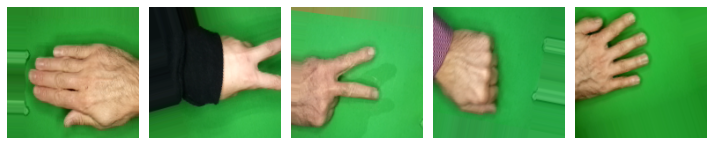

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


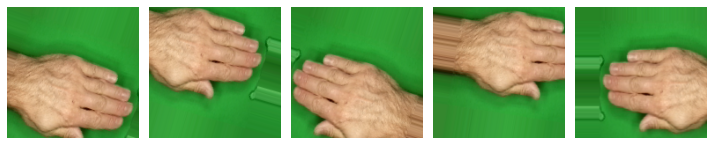

In [ ]:
# Visualisasi

# Fungsi Untuk Plot Gambar
def plotImages(images_array):
    fig, axes = plt.subplots(1, 5, figsize=(10,8))
    axes = axes.flatten()
    for img, ax in zip( images_array, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Plot Visualiasi beberapa Gambar
sample_training_images, _ = next(train_generator)
plotImages(sample_training_images[:5])

print('')
# Plot Visualisasi Augmentasi untuk 1 Gambar
augmented_images = [train_generator[0][0][0] for i in range(5)]
plotImages(augmented_images)

## CNN

### Pembuatan Model

In [ ]:
%%time

# Pengaturan Layer CNN + Penambahan DropOut
model = Sequential()
model.add(Conv2D(32, (3,3), input_shape=(150, 150, 3), activation = 'relu'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(32,(3,3), activation= 'relu'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(64,(3,3), activation= 'relu'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(128,(3,3), activation= 'relu'))
model.add(MaxPooling2D(2,2))
model.add(Flatten())
model.add(Dense(512, activation= 'relu'))
model.add(Dropout(0.5))
#model.add(Dense(64, activation= 'relu'))
#model.add(Dropout(0.5))
model.add(Dense(3, activation= 'softmax'))

# Kompilasi Model CNN
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics=['accuracy'])

# Summary Layer
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       7

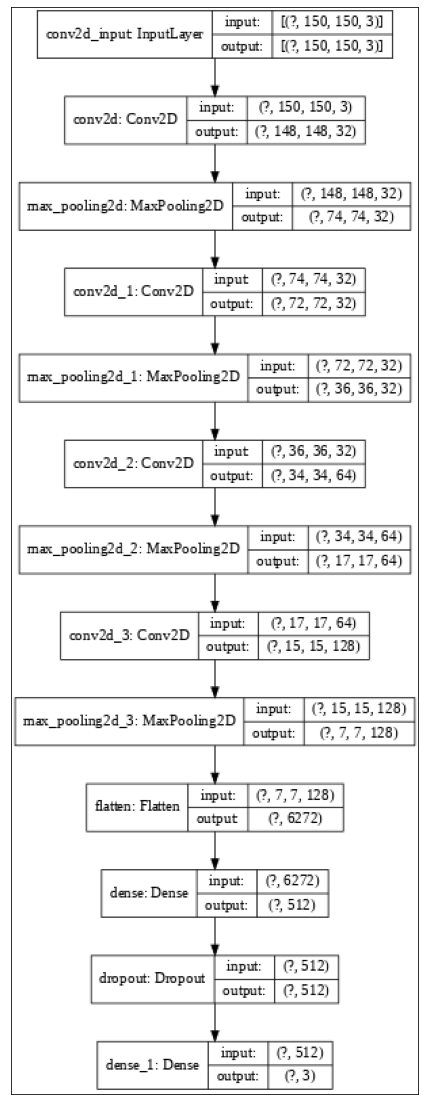

In [ ]:
# Visualisasi Model

visualiasi_model = plot_model(
    model,
    to_file=('/content/visualisasi_model_cnn.png'),
    show_shapes=True,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=True,
    dpi=55 )

plt.figure(figsize=(40,20))
plt.xticks([])
plt.yticks([])
plt.imshow(load_img('/content/visualisasi_model_cnn.png'))
plt.show()

### Training Model

In [ ]:
# Pengaturan Callback dan Penyimpanan Model

checkpoint = ModelCheckpoint('/content/model_cnn.h5',
                             monitor='val_accuracy',
                             verbose=1, save_best_only=True,
                             mode='max', 
                             save_weights_only=False
                             )
early_stopping = EarlyStopping(monitor='val_loss',
                               min_delta=0,
                               patience = 5,
                               verbose = 1,
                               restore_best_weights=True
                               )

callbacks_list = [checkpoint, early_stopping]

In [ ]:
%%time
history = model.fit(train_generator,
                    steps_per_epoch=total_train//batch_size, 
                    #epochs = epochs,
                    epochs=50, 
                    validation_data=val_generator,
                    validation_steps=total_val//batch_size,
                    verbose=1,
                    callbacks=callbacks_list
                    )

Epoch 1/50
41/41 [==============================] - ETA: 0s - loss: 1.0524 - accuracy: 0.4299
Epoch 00001: val_accuracy improved from -inf to 0.46528, saving model to /content/model_cnn.h5
41/41 [==============================] - 17s 419ms/step - loss: 1.0524 - accuracy: 0.4299 - val_loss: 0.9825 - val_accuracy: 0.4653
Epoch 2/50
41/41 [==============================] - ETA: 0s - loss: 0.7392 - accuracy: 0.6715
Epoch 00002: val_accuracy improved from 0.46528 to 0.78125, saving model to /content/model_cnn.h5
41/41 [==============================] - 17s 420ms/step - loss: 0.7392 - accuracy: 0.6715 - val_loss: 0.5180 - val_accuracy: 0.7812
Epoch 3/50
41/41 [==============================] - ETA: 0s - loss: 0.2764 - accuracy: 0.9116
Epoch 00003: val_accuracy improved from 0.78125 to 0.94329, saving model to /content/model_cnn.h5
41/41 [==============================] - 17s 418ms/step - loss: 0.2764 - accuracy: 0.9116 - val_loss: 0.1748 - val_accuracy: 0.9433
Epoch 4/50
41/41 [=============

### Evaluasi Model

In [ ]:
# Fungsi Plot Akurasi dan Loss

def plot_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].set_title('loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    
    ax[1].set_title('acc')
    ax[1].plot(history.epoch, history.history["accuracy"], label="Train acc")
    ax[1].plot(history.epoch, history.history["val_accuracy"], label="Validation acc")
    ax[0].legend()
    ax[1].legend()

In [ ]:
model_score = model.evaluate(val_generator,
                             steps=10,
                             verbose=0
                             )

print(f'{"Model Test Loss":<35}{model_score[0]}')
print(f'{"Model Test Accuracy":<35}{model_score[1]}')

Model Test Loss                    0.05320899561047554
Model Test Accuracy                0.984375


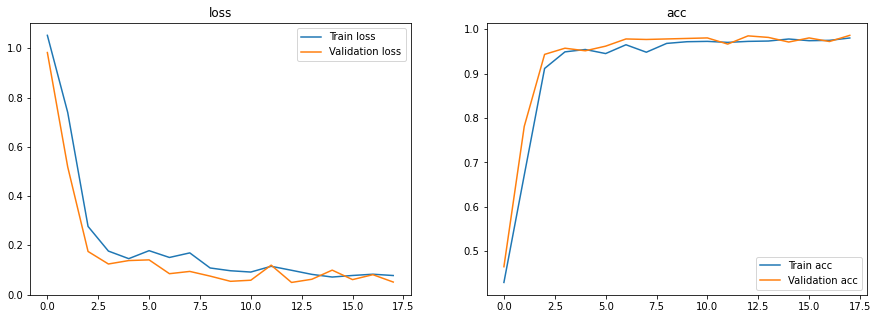

In [ ]:
 plot_history(history)

### Prediksi

Saving 1vQCX4af6hQmuwxZ.png to 1vQCX4af6hQmuwxZ.png
Saving 0eqArS2GgsBeqgSn.png to 0eqArS2GgsBeqgSn.png
Saving 00nKV8oHuTGi20gq.png to 00nKV8oHuTGi20gq.png


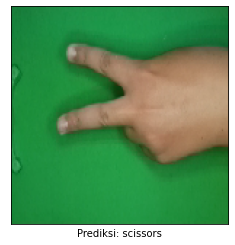

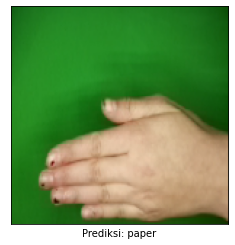

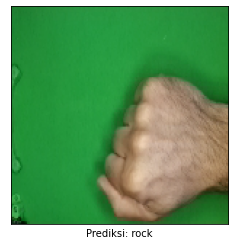

In [ ]:
from google.colab import files
 
uploaded = files.upload() # Bisa Upload Sekaligus/Tunggal
for fn in uploaded.keys():      
  img = load_img(fn, target_size=(150,150))    
  x = img_to_array(img)  
  x = np.expand_dims(x, axis=0) 
  images = np.vstack([x])    
  classes = model.predict(images, batch_size=10)
    
  if classes[0,0]!=0:
    prediksi = 'Prediksi: paper'
  elif classes[0,1]!=0:
    prediksi = 'Prediksi: rock'
  else:
    prediksi = 'Prediksi: scissors'
  
  plt.figure()
  plt.imshow(img)
  plt.xlabel(prediksi)
  plt.xticks([])
  plt.yticks([])